# Covid Infections and Deaths With Healthcare Costs


##### This notebook contains code to:
* Gather data from the Covid Tracking Project and load it into lists
* Add the lists to a dictionary.
* Create a dataframe from the dictionary.
* Create a dataframe from the census data
* Merge the Covid Tracking Project Data and Census Data
* Create a plot of the COVID-19 infections
* Calculate quantiles, IQR and outliers for outliers for covid infections
* Create a box plot of COVID19 deaths
* Calculate quantiles, IQR and outliers for outliers for covid deaths
* Create a scatter plot of COVID-19 infections and deaths.
* Create a box plot of Covid-19 Infections Per Capita
* Calculate quantiles, IQR and outliers for outliers for covid infections per capita
* Create a box plot of COVID-19 Deaths Per Capita
* Calculate quantiles, IQR and outliers for outliers for covid deaths per capita
* Plot a scatter plot of covid infections per capita and deaths per capita along with annotations of linear regression equation.
* Plot a scatter plot of covid infections per capita and healthcare costs per capita along with annotations of linear regression equation, r-squared value and p-value.
* Plot a scatter plot of covid deaths (mortality) per capita and healthcare costs per capita along with annotations of linear regression equation, r-squared value and p-value
* Create a new dataframe that just shows states, covid positive and healthcare costs per capita
* Sort the dataframe by healthcare costs per capita
* Reset the index of the dataframe and create a bar plot of healthcare costs per capita by state

In [54]:
import requests
from random import uniform 
from pprint import pprint
import pandas as pd
import numpy as np
import os
import scipy.stats as sts

from config import api_key
from census import Census
import matplotlib.pyplot as plt

# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"

covid_json = requests.get(url).json()

#PPrint the first state in list to evaluate list items
#Field description for variables can be found here : https://covidtracking.com/data/api 
pprint(covid_json[0])

{'checkTimeEt': '09/20 23:59',
 'commercialScore': 0,
 'dataQualityGrade': 'A',
 'date': 20200921,
 'dateChecked': '2020-09-21T03:59:00Z',
 'dateModified': '2020-09-21T03:59:00Z',
 'death': 45,
 'deathConfirmed': 45,
 'deathIncrease': 0,
 'deathProbable': None,
 'fips': '02',
 'grade': '',
 'hash': '2ec1459d557a0a9f8c65f1d11f0e2ac4bdf025f3',
 'hospitalized': None,
 'hospitalizedCumulative': None,
 'hospitalizedCurrently': 47,
 'hospitalizedIncrease': 0,
 'inIcuCumulative': None,
 'inIcuCurrently': None,
 'lastUpdateEt': '9/21/2020 03:59',
 'negative': 420807,
 'negativeIncrease': 1649,
 'negativeRegularScore': 0,
 'negativeScore': 0,
 'negativeTestsAntibody': None,
 'negativeTestsPeopleAntibody': None,
 'negativeTestsViral': 421275,
 'onVentilatorCumulative': None,
 'onVentilatorCurrently': 13,
 'pending': None,
 'posNeg': 428645,
 'positive': 7838,
 'positiveCasesViral': 7838,
 'positiveIncrease': 71,
 'positiveScore': 0,
 'positiveTestsAntibody': None,
 'positiveTestsAntigen': None,


#### Gather data from the Covid Tracking Project and load it into lists

In [55]:
states= []
deaths= []
hospitalized = []
covid_positives = []
dates = []
fips_list=[]

indices = list( range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips_list.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    hospitalized.append(covid_json[i]['hospitalizedCumulative'])
    covid_positives.append(covid_json[i]['positive'])
    

#### Add the lists to a dictionary.
#### Create a dataframe from the dictionary.

In [56]:
AllStates_dict = {
    "States": states,
    "FIPS": fips_list,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Cumaltive Hospitalized": hospitalized,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict)
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths
0,AK,02,20200921,7838,NaN,45
1,AL,01,20200921,145780,16487.0,2439
2,AR,05,20200921,76364,4986.0,1197
3,AS,60,20200921,0,NaN,0
4,AZ,04,20200921,214251,21878.0,5478


#### Connect to the Census API and gather 2018 ACS-5 Total Population Data
#### Create a dataframe from the census data

In [57]:
# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'state:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_TotalPop_df = pd.DataFrame(census_data)
census_TotalPop_df.head()

Number of available variables: 4


,NAME,state,Estimate!!Total
0,Minnesota,27,5527358.0
1,Mississippi,28,2988762.0
2,Missouri,29,6090062.0
3,Montana,30,1041732.0
4,Nebraska,31,1904760.0


#### Merge the Covid Tracking Project Data and Census Data

In [58]:
AllStates_df['State Pop']= ""
AllStates_df['Covid Positive Per 100,000']= ""
AllStates_df['Covid Deaths Per 100,000']= ""
AllStates_df

AllState_combined_df = pd.merge(AllStates_df, census_TotalPop_df, how='left', left_on = 'FIPS', right_on = 'state')
AllState_combined_df['State Pop'] = AllState_combined_df['Estimate!!Total']
AllState_combined_df['Covid Positive Per 100,000'] = (AllState_combined_df['Covid Positive'] / AllState_combined_df['State Pop'])*100000 
AllState_combined_df['Covid Deaths Per 100,000'] = (AllState_combined_df['Deaths'] / AllState_combined_df['State Pop'])*100000 
AllState_combined_dropC = AllState_combined_df.drop(columns=['Cumaltive Hospitalized', 'state','Estimate!!Total'])

#drop rows
AllState_combined_clean = AllState_combined_dropC.dropna(axis=0, how='any')

file_path = os.path.join("Input","Per Capita Personal Health Care.csv") 
percapita_data = pd.read_csv(file_path)


AllState_with_costs = pd.merge(AllState_combined_clean , percapita_data, how='left', on = 'States')
AllState_with_costs = AllState_with_costs.dropna(axis=0, how='any')

AllState_with_costs= AllState_with_costs.rename(columns = {"TAP Per Capita State Est Personal Health Care (Dollars)": "Healthcare Costs Per Capita"})
AllState_with_costs.head()

,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME,Healthcare Costs Per Capita
0,AK,02,20200921,7838,45,738516.0,1061.317561,6.093301,Alaska,11064.0
1,AL,01,20200921,145780,2439,4864680.0,2996.702764,50.136905,Alabama,7281.0
2,AR,05,20200921,76364,1197,2990671.0,2553.406911,40.024463,Arkansas,7408.0
3,AZ,04,20200921,214251,5478,6946685.0,3084.219307,78.857757,Arizona,6452.0
4,CA,06,20200921,781694,15018,39148760.0,1996.727355,38.361368,California,7549.0


#### Create a plot of the COVID-19 infections

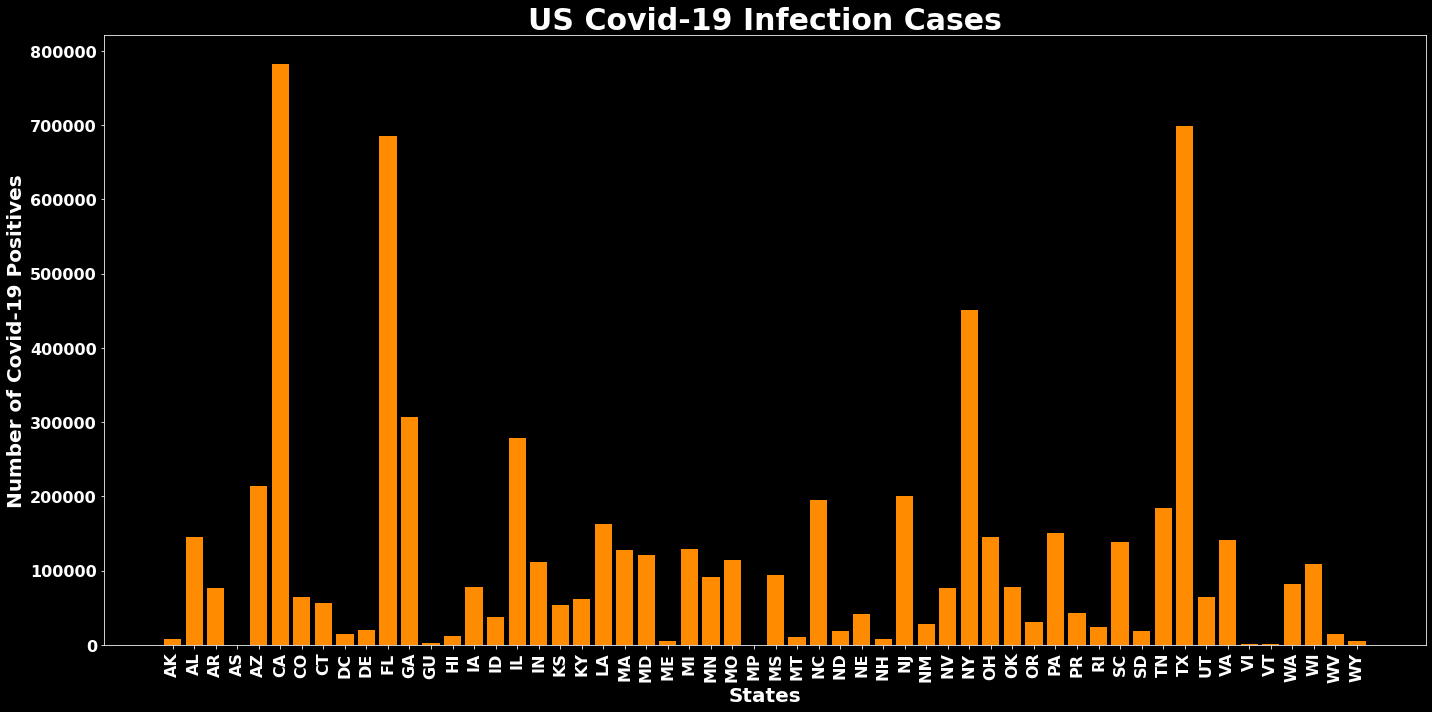

In [59]:

x_axis = np.arange(len(AllStates_df))
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.bar(x_axis, AllStates_df["Covid Positive"], color='darkorange')
plt.title("US Covid-19 Infection Cases", fontsize=30, weight='bold')
plt.xlabel("States", fontsize=20, weight='bold')
plt.ylabel("Number of Covid-19 Positives", fontsize=20, weight='bold')
x = plt.xticks(x_axis, AllStates_df["States"], rotation="vertical", fontsize=16, weight='bold')
plt.yticks(fontsize=16, weight='bold')

plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_State_Infections_transparent.png')
plt.savefig(outfile, transparent=True)

# Are there states that are outliers for COVID19 Infections?

#### Create a box plot of Covid-19 Infections

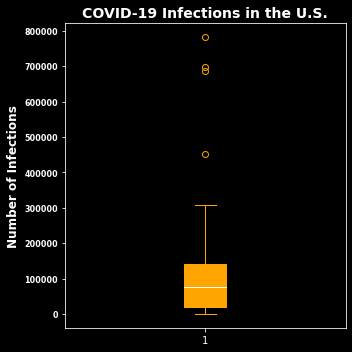

In [60]:
covid19_infxn = AllStates_df['Covid Positive']

# Set color to orange
c = 'orange'
# Create dictionary of keyword aruments to pass to plt.boxplot
orange_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor=c),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c),
             'medianprops': dict(color="white"),
             'whiskerprops': dict(color=c)}

plt.figure(figsize=(5,5))
plt.title('COVID-19 Infections in the U.S.', fontsize=14, weight='bold')
plt.ylabel('Number of Infections', fontsize=12, weight='bold')
plt.yticks(fontsize=8, weight='bold')
plt.boxplot(covid19_infxn, **orange_dict)

plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Infections_Boxplot_Transparent.png')
plt.savefig(outfile, transparent=True)

plt.show()




#### Calculate quantiles, IQR and outliers for outliers for covid infections

In [61]:
quantiles = covid19_infxn.quantile([.25,.5,.75])
quantiles

0.25     18712.75
0.50     76200.00
0.75    142144.75
Name: Covid Positive, dtype: float64

In [62]:
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Infections is: {Q1}")
print(f"The upper quartile of COVID19 Infections is: {Q3}")
print(f"The interquartile range of COVID19 Infections is: {iqr}")
print(f"The the median of COVID19 Infections is: {quantiles[0.5]} ")


The lower quartile of COVID19 Infections is: 18712.75
The upper quartile of COVID19 Infections is: 142144.75
The interquartile range of COVID19 Infections is: 123432.0
The the median of COVID19 Infections is: 76200.0 


In [63]:
lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -166435.25 could be outliers.
Values above 327292.75 could be outliers.


In [64]:
outliers = AllStates_df.loc[(AllStates_df['Covid Positive'] < lower_bound) | (AllStates_df['Covid Positive'] > upper_bound)]
outliers

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000"
5,CA,06,20200921,781694,NaN,15018,,,
10,FL,12,20200921,685439,43033.0,13480,,,
37,NY,36,20200921,450473,89995.0,25428,,,
47,TX,48,20200921,698387,NaN,14917,,,


In [66]:
print("These states are outliers in USA for COVID19 Infections:")
print(outliers['States'])

These states are outliers in USA for COVID19 Infections:
5     CA
10    FL
37    NY
47    TX
Name: States, dtype: object


# Are there states that are outliers for COVID19 deaths?
#### Create a box plot of COVID19 deaths

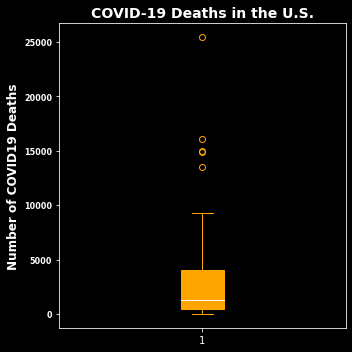

In [68]:
covid_deaths = AllStates_df['Deaths']
# Set color to orange
c = 'orange'
# Create dictionary of keyword aruments to pass to plt.boxplot
orange_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor=c),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c),
             'medianprops': dict(color="white"),
             'whiskerprops': dict(color=c)}

plt.figure(figsize=(5,5))
plt.title('COVID-19 Deaths in the U.S.', fontsize=14, weight='bold')
plt.ylabel('Number of COVID19 Deaths', fontsize=12, weight='bold')
plt.yticks(fontsize=8, weight='bold')
plt.boxplot(covid_deaths, **orange_dict)
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Deaths_Boxplot_Transparent.png')
plt.savefig(outfile, transparent=True)


plt.show()

#### Calculate quantiles, IQR and outliers for outliers for covid deaths

In [69]:
quartiles = covid_deaths.quantile([.25,.5,.75])
quartiles

0.25     440.25
0.50    1263.00
0.75    4036.00
Name: Deaths, dtype: float64

In [70]:
Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Deaths is: {Q1}")
print(f"The upper quartile of COVID19 Deaths is: {Q3}")
print(f"The interquartile range of COVID19 Deaths is: {iqr}")
print(f"The the median of COVID19 Deaths is: {quartiles[0.5]} ")


The lower quartile of COVID19 Deaths is: 440.25
The upper quartile of COVID19 Deaths is: 4036.0
The interquartile range of COVID19 Deaths is: 3595.75
The the median of COVID19 Deaths is: 1263.0 


In [71]:
lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -4953.375 could be outliers.
Values above 9429.625 could be outliers.


In [72]:
outliers = AllStates_df.loc[(AllStates_df['Deaths'] < lower_bound) | (AllStates_df['Deaths'] > upper_bound)]
outliers

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000"
5,CA,06,20200921,781694,NaN,15018,,,
10,FL,12,20200921,685439,43033.0,13480,,,
34,NJ,34,20200921,200154,23135.0,16069,,,
37,NY,36,20200921,450473,89995.0,25428,,,
47,TX,48,20200921,698387,NaN,14917,,,


#### Create a scatter plot of COVID-19 infections and deaths.

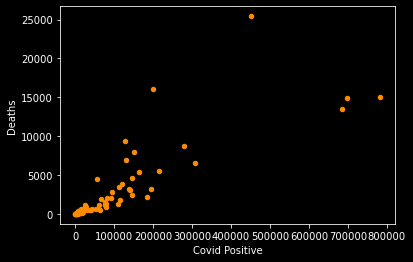

In [73]:
AllStates_df.plot.scatter(x='Covid Positive',
                      y='Deaths',
                      c='darkorange')

#### Calculate the correlation coefficient and p-value

In [74]:
correlation = sts.pearsonr(covid19_infxn, covid_deaths)

print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

The correlation coefficient (r) is 0.82
The p-value is 1.2170285924863895e-14


#### Calculate the linear regression

In [75]:
# from sklearn import datasets

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = sts.linregress(covid19_infxn, covid_deaths)

# Calculate the predictions for each value of x (# Rooms)
regression_values = covid19_infxn * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


#### Plot a scatter plot of covid infections and deaths along with annotations of linear regression equation, r-squared value and p-value.

The r-squared is: 0.6708785293443296


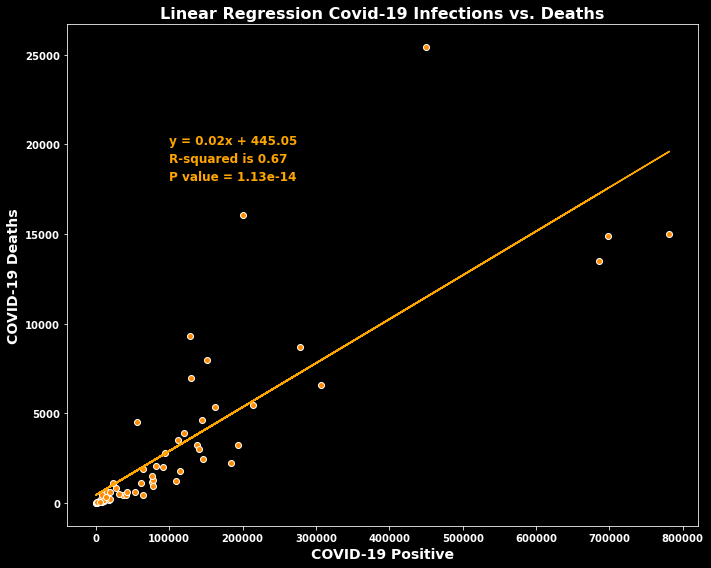

In [76]:
pvalue_str = "P value = 1.13e-14"

r2 = "R-squared is 0.67"

color = 'orange'
plt.figure(figsize=(10,8))
# Plot observations
plt.scatter(covid19_infxn, covid_deaths, marker="o", facecolors="darkorange", edgecolors="white")

# Plot the regression line
plt.plot(covid19_infxn, regression_values, color)

# Annotate the plot with the linear equation
plt.annotate(line_eq, (100000, 20000), fontsize=12, weight='bold', color=color)
plt.annotate(r2, (100000, 19000), fontsize=12, weight='bold', color=color)
plt.annotate(pvalue_str, (100000, 18000), fontsize=12, weight='bold', color=color)
plt.xlabel('COVID-19 Positive', fontsize=14, weight='bold')
plt.ylabel('COVID-19 Deaths', fontsize=14, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.title('Linear Regression Covid-19 Infections vs. Deaths', fontsize=16, weight='bold')
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Infections_Deaths_LR_Transparent.png')
plt.savefig(outfile, transparent=True)


print(f"The r-squared is: {rvalue**2}")
plt.show()

# COVID19 Infections Per Capita

#### Create a box plot of Covid-19 Infections Per Capita

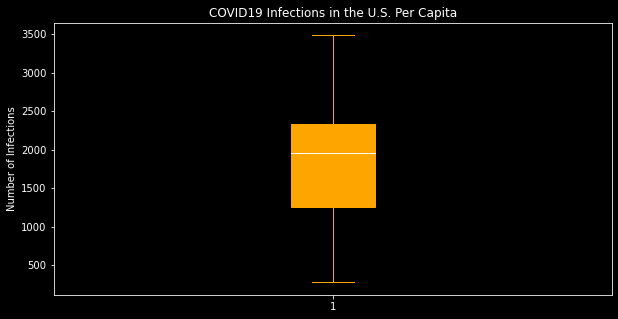

In [77]:
covid19_infxn_capita = AllState_combined_clean['Covid Positive Per 100,000']
# Set color to orange
c = 'orange'
# Create dictionary of keyword aruments to pass to plt.boxplot
orange_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor=c),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c),
             'medianprops': dict(color="white"),
             'whiskerprops': dict(color=c)}

plt.figure(figsize=(10,5))
plt.title('COVID19 Infections in the U.S. Per Capita')
plt.ylabel('Number of Infections')
plt.boxplot(covid19_infxn_capita, **orange_dict)
plt.show()


#### Calculate quantiles, IQR and outliers for outliers for covid infections per capita

In [78]:
quartiles = covid19_infxn_capita.quantile([.25,.5,.75])

Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Infections per 100,000 is: {Q1}")
print(f"The upper quartile of COVID19 Infections per 100,000 is: {Q3}")
print(f"The interquartile range of COVID19 Infections per 100,000 is: {iqr}")
print(f"The the median of COVID19 Infections per 100,000 is: {quartiles[0.5]} ")

lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outliers = AllState_combined_clean.loc[(AllState_combined_clean['Covid Positive Per 100,000'] < lower_bound) | (AllState_combined_clean['Covid Positive Per 100,000'] > upper_bound)]
outliers

The lower quartile of COVID19 Infections per 100,000 is: 1252.3134347617568
The upper quartile of COVID19 Infections per 100,000 is: 2328.481263503636
The interquartile range of COVID19 Infections per 100,000 is: 1076.1678287418792
The the median of COVID19 Infections per 100,000 is: 1951.208589621568 
Values below -361.93830835106223 could be outliers.
Values above 3942.733006616455 could be outliers.


,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME


#### Create a box plot of COVID-19 Deaths Per Capita

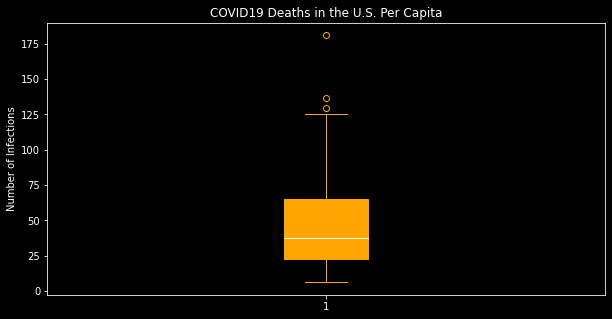

In [79]:
covid19_deaths_capita = AllState_combined_clean['Covid Deaths Per 100,000']

# Set color to orange
c = 'orange'
# Create dictionary of keyword aruments to pass to plt.boxplot
orange_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor=c),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c),
             'medianprops': dict(color="white"),
             'whiskerprops': dict(color=c)}


plt.figure(figsize=(10,5))
plt.title('COVID19 Deaths in the U.S. Per Capita')
plt.ylabel('Number of Infections')
plt.boxplot(covid19_deaths_capita, **orange_dict)
plt.show()


#### Calculate quantiles, IQR and outliers for outliers for covid deaths per capita

In [80]:
quartiles = covid19_deaths_capita.quantile([.25,.5,.75])

Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Deaths per 100,000 is: {Q1}")
print(f"The upper quartile of COVID19 Deaths per 100,000 is: {Q3}")
print(f"The interquartile range of COVID19 Deaths per 100,000 is: {iqr}")
print(f"The the median of COVID19 Deaths per 100,000 is: {quartiles[0.5]} ")

lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outliers = AllState_combined_clean.loc[(AllState_combined_clean['Covid Deaths Per 100,000'] < lower_bound) | (AllState_combined_clean['Covid Deaths Per 100,000'] > upper_bound)]
outliers

The lower quartile of COVID19 Deaths per 100,000 is: 22.820497380989448
The upper quartile of COVID19 Deaths per 100,000 is: 64.96918510811251
The interquartile range of COVID19 Deaths per 100,000 is: 42.14868772712306
The the median of COVID19 Deaths per 100,000 is: 37.46247446286092 
Values below -40.40253420969515 could be outliers.
Values above 128.1922166987971 could be outliers.


,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME
21,MA,25,20200921,127796,9317,6830193.0,1871.045225,136.409030,Massachusetts
34,NJ,34,20200921,200154,16069,8881845.0,2253.518272,180.919617,New Jersey
37,NY,36,20200921,450473,25428,19618453.0,2296.169836,129.612666,New York


#### Plot a scatter plot of covid infections per capita and deaths per capita along with annotations of linear regression equation.

The correlation coefficient (r) is 0.47
The p-value is 0.0004656426852475839
The r-squared is: 0.21915571333949602


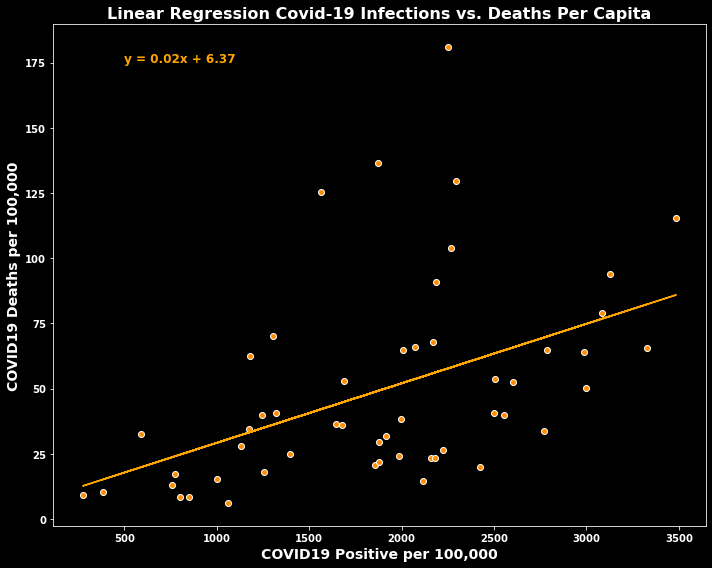

In [81]:
correlation = sts.pearsonr(covid19_infxn_capita, covid19_deaths_capita)

print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")


# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = sts.linregress(covid19_infxn_capita, covid19_deaths_capita)

# Calculate the predictions for each value of x (# Rooms)
regression_values = covid19_infxn_capita * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

color = 'orange'
plt.figure(figsize=(10,8))
# Plot observations
plt.scatter(covid19_infxn_capita, covid19_deaths_capita, marker="o", facecolors="darkorange", edgecolors="white")

# Plot the regression line
plt.plot(covid19_infxn_capita, regression_values, color)

# Annotate the plot with the linear equation
plt.annotate(line_eq, (500, 175), fontsize=12, weight='bold', color=color)
plt.xlabel('COVID19 Positive per 100,000', fontsize=14, weight='bold')
plt.ylabel('COVID19 Deaths per 100,000', fontsize=14, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.title('Linear Regression Covid-19 Infections vs. Deaths Per Capita', fontsize=16, weight='bold')
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Infections_Deaths_PC_LR_Transparent.png')
plt.savefig(outfile, transparent=True)


print(f"The r-squared is: {rvalue**2}")
plt.show()




In [82]:
AllState_with_costs['Healthcare Costs Per Capita'].head()

0    11064.0
1     7281.0
2     7408.0
3     6452.0
4     7549.0
Name: Healthcare Costs Per Capita, dtype: float64

# Correlation of Infections vs. Healthcare costs

#### Plot a scatter plot of covid infections per capita and healthcare costs per capita along with annotations of linear regression equation, r-squared value and p-value.

The correlation coefficient (r) is -0.4
The p-value is 0.004243644643858409


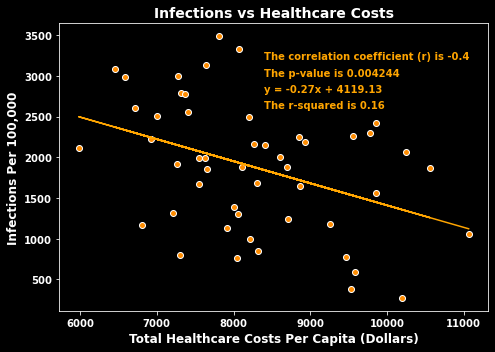

In [83]:
plt.figure(figsize=(7,5))
plt.scatter(x=AllState_with_costs['Healthcare Costs Per Capita'], y=AllState_with_costs['Covid Positive Per 100,000'], marker="o", facecolors="darkorange", edgecolors="white")
plt.ylabel("Infections Per 100,000", fontsize=12, weight='bold')
plt.xlabel("Total Healthcare Costs Per Capita (Dollars)", fontsize=12, weight='bold')
plt.title("Infections vs Healthcare Costs", fontsize=14, weight='bold')
correlation = sts.pearsonr(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Positive Per 100,000'])
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = sts.linregress(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Positive Per 100,000'])
# Calculate the predictions for each value of x (# Rooms)
regression_values = AllState_with_costs['Healthcare Costs Per Capita'] * slope + intercept
# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

color = 'orange'
# Plot the regression line
plt.plot(AllState_with_costs['Healthcare Costs Per Capita'], regression_values, color)

# Annotate the plot with the linear equation
plt.annotate(f"The correlation coefficient (r) is {round(correlation[0],2)}", (8400, 3200), fontsize=10, weight='bold', color=color)
plt.annotate(f"The p-value is {round(correlation[1], 6)}", (8400, 3000), fontsize=10, weight='bold', color=color)
plt.annotate(line_eq, (8400, 2800), fontsize=10, weight='bold', color=color)
plt.annotate(f"The r-squared is {round(rvalue**2, 2)}", (8400, 2600), fontsize=10, weight='bold', color=color )
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_InfectionsVHealthcareCosts.png')
plt.savefig(outfile, transparent=True)

plt.show()


# Correlation of Mortality vs. Healthcare costs

#### Plot a scatter plot of covid deaths (mortality) per capita and healthcare costs per capita along with annotations of linear regression equation, r-squared value and p-value

The correlation coefficient (r) is 0.17
The p-value is 0.23364914321391966


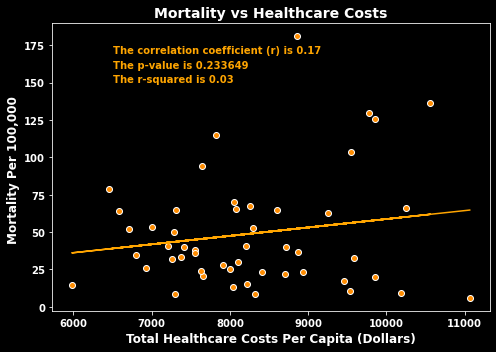

In [84]:

plt.figure(figsize=(7,5))
plt.scatter(x=AllState_with_costs['Healthcare Costs Per Capita'], y=AllState_with_costs['Covid Deaths Per 100,000'], marker="o", facecolors="darkorange", edgecolors="white")
plt.ylabel("Mortality Per 100,000 ", fontsize=12, weight='bold')
plt.xlabel("Total Healthcare Costs Per Capita (Dollars)", fontsize=12, weight='bold')
plt.title("Mortality vs Healthcare Costs", fontsize=14, weight='bold')

correlation = sts.pearsonr(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Deaths Per 100,000'])
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")


# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = sts.linregress(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Deaths Per 100,000'])
# Calculate the predictions for each value of x (# Rooms)
regression_values = AllState_with_costs['Healthcare Costs Per Capita'] * slope + intercept
# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# Plot the regression line
plt.plot(AllState_with_costs['Healthcare Costs Per Capita'], regression_values, color)
# Annotate the plot with the linear equation
plt.annotate(f"The correlation coefficient (r) is {round(correlation[0],2)}", (6500, 170), fontsize=10, weight='bold', color=color)
plt.annotate(f"The p-value is {round(correlation[1], 6)}", (6500, 160), fontsize=10, weight='bold', color=color)
plt.annotate(f"The r-squared is {round(rvalue**2, 2)}", (6500, 150), fontsize=10, weight='bold', color=color )
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_MortalityVHealthcareCosts_Transparent.png')
plt.savefig(outfile, transparent=True)



plt.show()

#### Create a new dataframe that just shows states, covid positive and healthcare costs per capita

In [85]:
state_comparison = AllState_with_costs[['States', 'Covid Positive', 'Healthcare Costs Per Capita']]
state_comparison.head()

,States,Covid Positive,Healthcare Costs Per Capita
0,AK,7838,11064.0
1,AL,145780,7281.0
2,AR,76364,7408.0
3,AZ,214251,6452.0
4,CA,781694,7549.0


#### Sort the dataframe by healthcare costs per capita

In [86]:
state_comparison = state_comparison.sort_values(by=['Healthcare Costs Per Capita'])
state_comparison.head()

,States,Covid Positive,Healthcare Costs Per Capita
45,UT,64394,5982.0
3,AZ,214251,6452.0
10,GA,307339,6587.0
33,NV,76036,6714.0
5,CO,64857,6804.0


#### Reset the index of the dataframe and create a bar plot of healthcare costs per capita by state

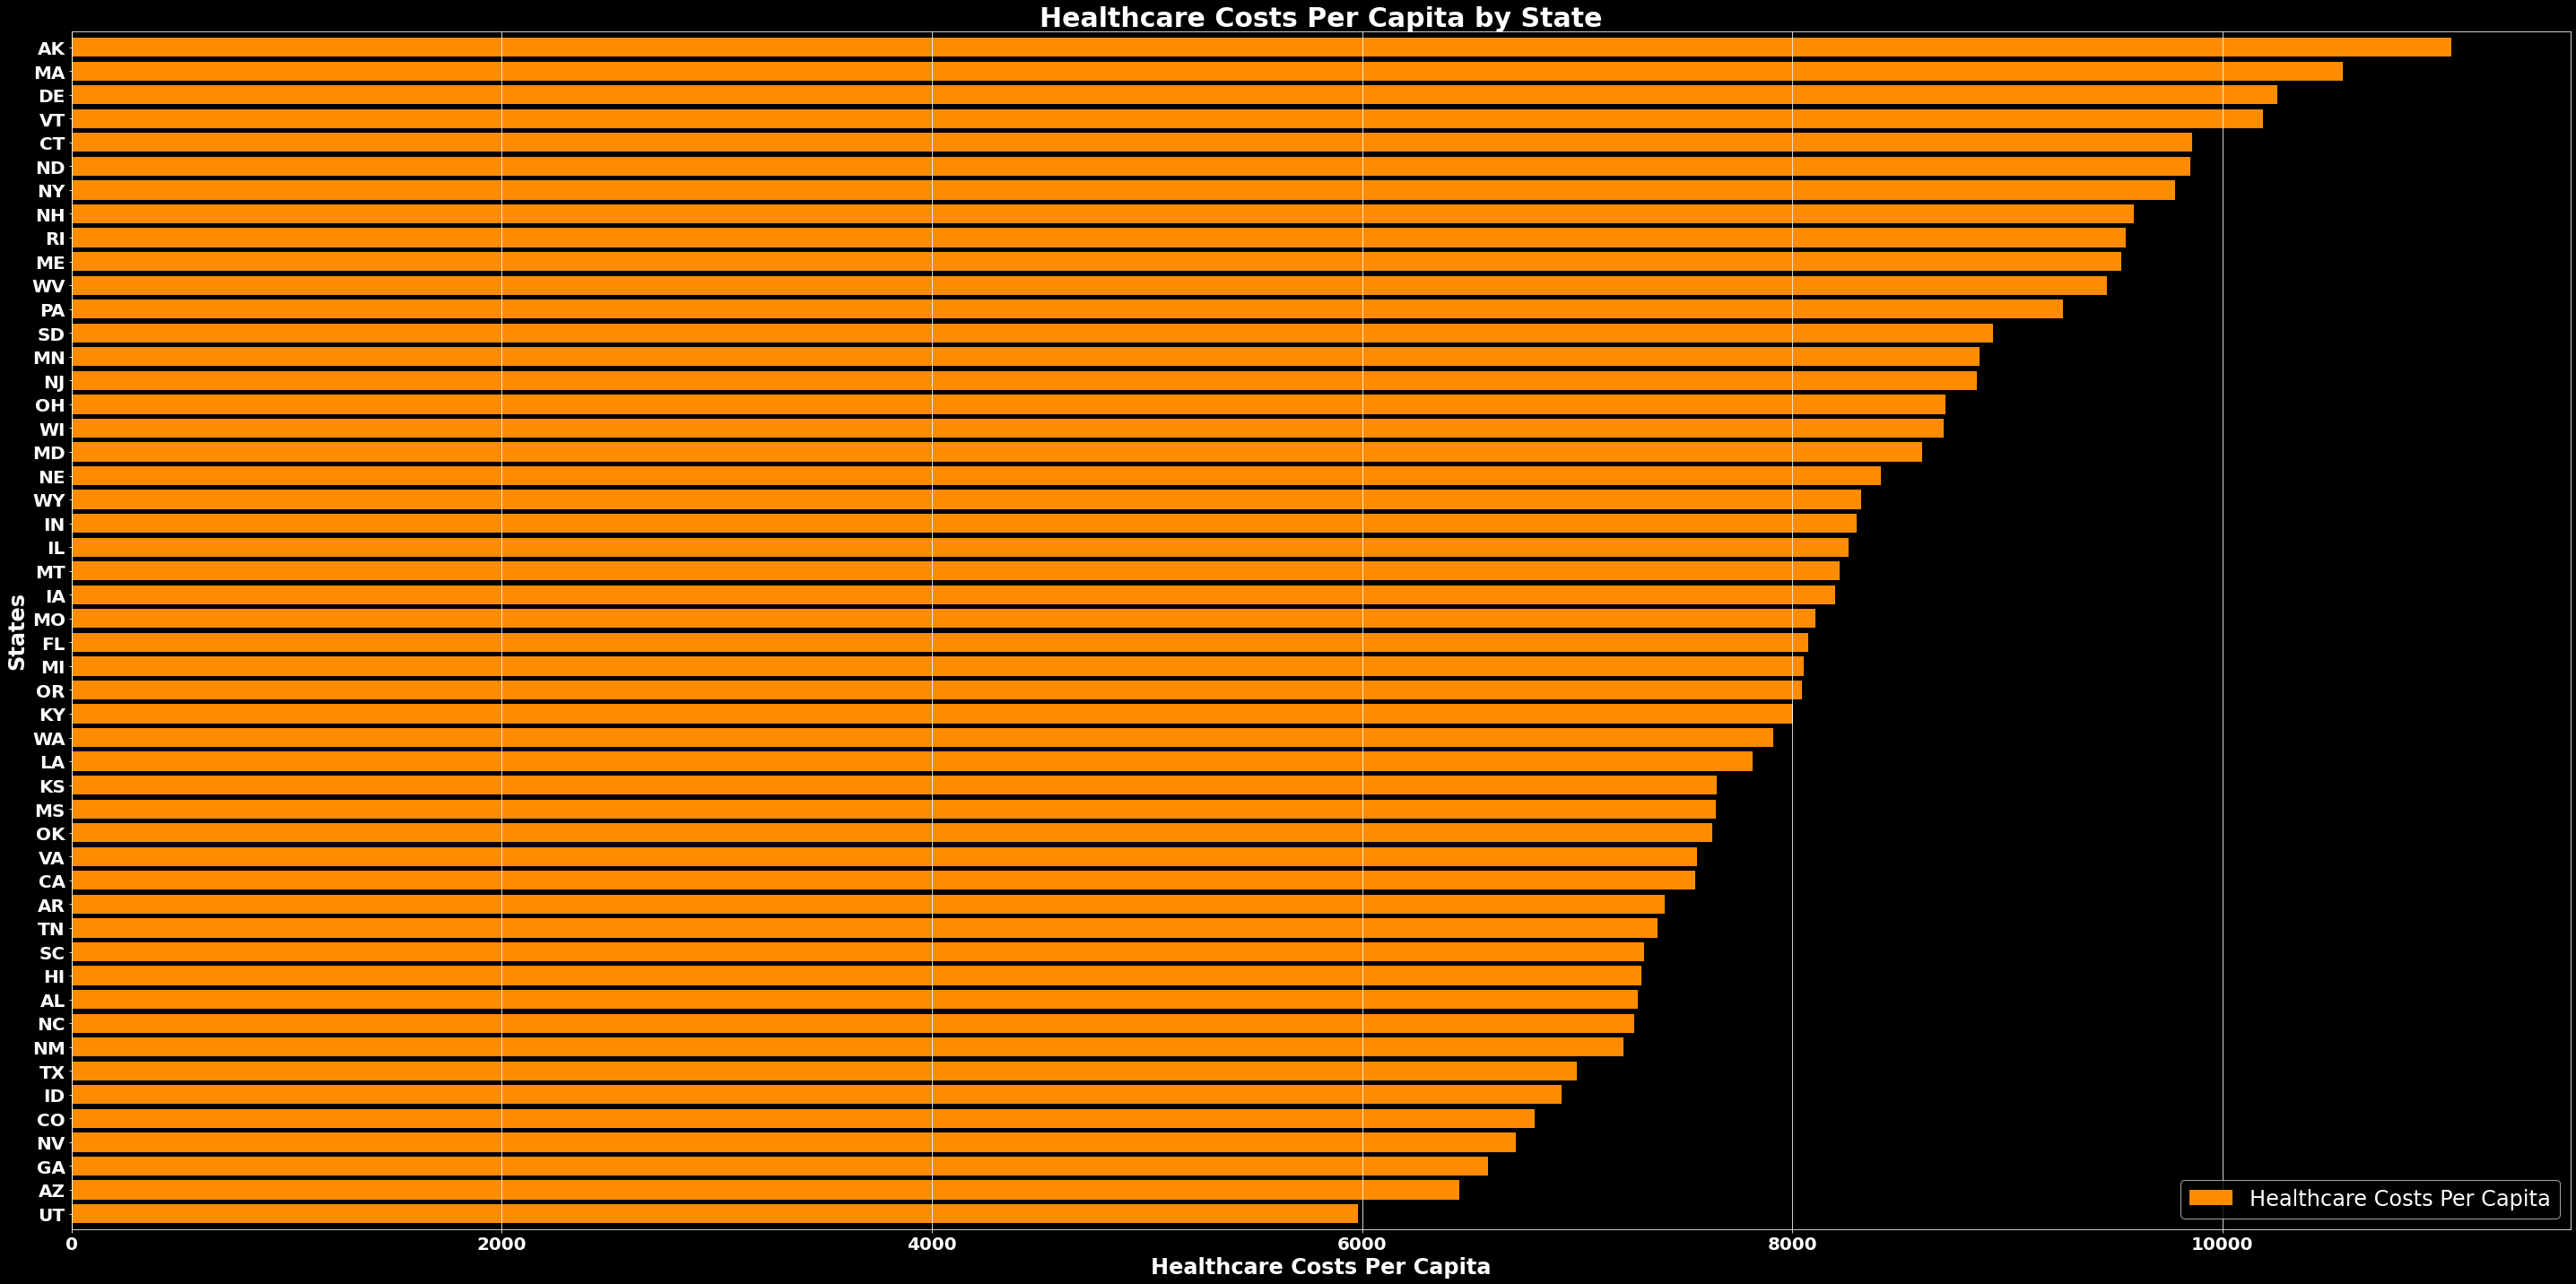

In [87]:
state_comparison  = state_comparison.reset_index(drop=True)

state_comparison.plot(kind='barh', y = 'Healthcare Costs Per Capita' , 
                                 figsize=(40,20), color='darkorange', width=0.8, stacked=True)
x_axis = state_comparison.index 
plt.yticks(x_axis, state_comparison['States'], fontsize=20, weight='bold')
plt.xticks(fontsize=20, weight='bold')
plt.xlabel("Healthcare Costs Per Capita", fontsize=24, weight='bold')
plt.ylabel("States", fontsize=24, weight='bold')
plt.grid(b=None, which='major', axis='x')
plt.title("Healthcare Costs Per Capita by State", fontsize=30, weight='bold')
plt.legend(fontsize=24)
plt.tight_layout()

outfile = os.path.join("Output", "Healthcare_Costs_Capita_States_Transparent.png")
plt.savefig(outfile, transparent=True)